In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import random
random.random_state = 0

# next command ensures that plots appear inside the notebook
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # also improves the look of plots
sns.set()
plt.rcParams['lines.markeredgewidth'] = 1  # to fix issue with seaborn box plots; needed after import seaborn
plt.rcParams["figure.figsize"] = [16, 11]
plt.rcParams["figure.autolayout"] = True
pd.set_option('display.max_rows', 1000)
pd.set_option("display.max_columns", 1000)

In [2]:
%%time
df_train = pd.read_csv('BPI_Challenge_2012-training.csv')
df_test = pd.read_csv('BPI_Challenge_2012-test.csv')

df_data = pd.concat([df_train, df_test])

df_data.drop(["eventID ","case REG_DATE"],axis=1,inplace=True)

df_data["next event"] = 0
df_data["prev event"] = 0

def next_event(data, lst):
    """function to add the next and previous event of a trace"""
    for i in lst:
        data.loc[data["case concept:name"] == i, "next event"] = data.loc[data["case concept:name"] == i, "event concept:name"].shift(-1)
    
        data.loc[data["case concept:name"] == i, "prev event"] = data.loc[data["case concept:name"] == i, "event concept:name"].shift(1)
    
    return data


next_event(df_data, df_data["case concept:name"].unique().tolist())
# Check a trace
#df_data.loc[df_data["case concept:name"] == df_data["case concept:name"].unique().tolist()[1261]];

df_encoded = df_data.copy()

df_encoded.iloc[-1] = 0

df_encoded.loc[47822, "next event"] = "A_SUBMITTED"

df_encoded.iloc[-1]

df_encoded.replace(0, np.nan, inplace=True)


from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

event_encoder = LabelEncoder()
time_of_day_encoder = OrdinalEncoder()

labels = df_encoded["event concept:name"].unique()
event_encoder.fit(labels)
df_encoded[["event concept:name", "next event", "prev event"]] = df_encoded[["event concept:name", "next event", "prev event"]].apply(event_encoder.fit_transform)

# Time of day implementation, not sure if correct.
df_encoded["time of day"] = df_encoded["event time:timestamp"].str.split(expand=True)[1]
time_of_day_encoder = OrdinalEncoder()
df_encoded["time of day"] = time_of_day_encoder.fit_transform(df_encoded[["time of day"]])

#df_encoded.drop(["event time:timestamp", "case concept:name"], axis=1, inplace=True)

df_encoded.dropna(inplace=True)

Wall time: 28.2 s


In [3]:
# New: Event lifecycle encoding
labels = df_encoded["event lifecycle:transition"].unique()
event_encoder.fit(labels)
df_encoded[["event lifecycle:transition"]] = df_encoded[["event lifecycle:transition"]].apply(event_encoder.fit_transform)


In [4]:
models = {}

## 31% test

0 = sklearn split 0.2

1 = 31-33% incorrect

2 = 26-27.5% incorrect

3 = 20-21.5% incorrect

4 = fixed lol 21% /8

5 = 24.5-25.5% /6.5

In [5]:
# To confirm split is proper.
test = df_encoded[df_encoded["case concept:name"].isin(random.sample(df_encoded["case concept:name"].tolist(), round(len(df_encoded["case concept:name"].unique())/8)))]["case concept:name"].unique()

train = df_encoded[~df_encoded["case concept:name"].isin(test)]["case concept:name"].unique()

test.shape, train.shape, pd.Series(test).isin(train).sum()

((1460,), (11626,), 0)

In [6]:
len(df_encoded[df_encoded["case concept:name"].isin(random.sample(df_encoded["case concept:name"].tolist(), round(len(df_encoded["case concept:name"].unique())/8)))])/len(df_encoded)

0.21377789982760462

In [7]:
def add(lst,dct=models):
    """
    Adds a model's results and data to a dict.
    """
    dct[len(dct)+1] = lst

def random_trace_split(data):

    test = data[data["case concept:name"].isin(random.sample(data["case concept:name"].tolist(), round(len(data["case concept:name"].unique())/8)))]

    train = data[~data["case concept:name"].isin(test["case concept:name"].unique())]

    X_test = test[[
#                    "case AMOUNT_REQ", 
                   "event concept:name", "prev event", "time of day", "event lifecycle:transition"]]
    y_test = test["next event"].values

    X_train = train[[
#                     "case AMOUNT_REQ", 
                    "event concept:name", "prev event", "time of day", "event lifecycle:transition"]]
    y_train = train["next event"].values
    return X_train, X_test, y_train, y_test
    
    
def testRFC():
    """
    For testing a RFC by inputting n_estimators and max_depth, rest = default
    """
    testRFC = RandomForestClassifier(n_estimators=int(input("n_estimators: ")), max_depth=int(input("max_depth: ")), random_state=0)
    testRFC.fit(X_train, y_train)
    y_pred = testRFC.predict(X_test)
    print("MSE: ",mean_squared_error(y_test, y_pred))
    print("Accuracy: ",accuracy_score(y_test, y_pred))
    print("Precision: ",precision_score(y_test, y_pred, average="weighted", zero_division=0))
    print("Recall: ",recall_score(y_test, y_pred, average="weighted", zero_division=0))
    print("F1: ",f1_score(y_test, y_pred, average="weighted", zero_division=0))    

def nRFC(n_estimators=False, max_depth=False, min_samples_leaf=False, criterion=False,bootstrap=False, random_sampling=4):
    """
    Trains a new RFC model and adds its results and data to a dict.
    Input: as argument or as input, if no arguments are specified it automatically prompts an input box.
    """
    if not n_estimators:
        n_estimators=int(input("n_estimators: "))
    if not max_depth:
        max_depth=int(input("max_depth: "))
    if not min_samples_leaf:
        min_samples_leaf=int(input("min_samples_leaf: "))
    if not criterion:
        criterion=str(input("criterion: "))
    
    #bootstrap = bool(input("bootstrap(T/F): "))
    print("n_estimators: ", n_estimators)
    print("max_depth: ", max_depth)
    print("min_samples_leaf: ", min_samples_leaf)
    print("criterion: ", criterion)
    print("bootstrap: ", bootstrap)
    print("Random Sampling; ", random_sampling)
    
    newRFC = RandomForestClassifier(bootstrap=bootstrap,
                                    criterion=criterion,
                                    n_estimators=n_estimators, 
                                    max_depth=max_depth, 
                                    min_samples_leaf=min_samples_leaf,
                                    random_state=0
                                   )
    newRFC.fit(X_train, y_train)
    y_pred = newRFC.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)
    
    features = newRFC.feature_names_in_
    importance = newRFC.feature_importances_
    values = [acc, f1, n_estimators, max_depth, min_samples_leaf, bootstrap, criterion, 
              list(features), list(importance), random_sampling]
    print(values)
    add(values)
    
    
def save_models(data):
    """
    Run to save model data as csv.
    """
    df_models_old = pd.read_csv("models.csv")
    df_models = pd.DataFrame.from_dict(models, columns = ["accuracy", "f1", "n_estimators", "max_depth", "min_samples_leaf", "bootstrap", "criterion", "predictors", "predictor importances", "Random Sampling"], orient="index")
    df_models = pd.concat([df_models_old, df_models])
#     df_models["Random Sampling"] = False
    df_models.drop_duplicates(subset=["accuracy", "f1", "max_depth", "n_estimators"], inplace=True)
    df_models.to_csv('models.csv', index=False)
    return df_models



df_models = pd.DataFrame.from_dict(models, columns = ["accuracy", "f1", "n_estimators", "max_depth", "min_samples_leaf", "bootstrap", "criterion", "predictors", "predictor importances", "Random Sampling"], orient="index")
df_models = save_models(df_models)

X_train, X_test, y_train, y_test = random_trace_split(df_encoded)

In [30]:
[nRFC(20,i,2,"entropy", True) for i in [14,15,16,17,18,19]]

n_estimators:  40
max_depth:  14
min_samples_leaf:  2
criterion:  entropy
bootstrap:  True
Random Sampling;  4
[0.8399950347567031, 0.8247725535751254, 40, 14, 2, True, 'entropy', ['event concept:name', 'prev event', 'time of day', 'event lifecycle:transition'], [0.43020852582207786, 0.4423927089639907, 0.04766196169678137, 0.07973680351715007], 4]
n_estimators:  40
max_depth:  15
min_samples_leaf:  2
criterion:  entropy
bootstrap:  True
Random Sampling;  4
[0.8391261171797418, 0.8243144194174554, 40, 15, 2, True, 'entropy', ['event concept:name', 'prev event', 'time of day', 'event lifecycle:transition'], [0.42739748093859464, 0.44378243274089013, 0.05116593093685275, 0.07765415538366253], 4]
n_estimators:  40
max_depth:  16
min_samples_leaf:  2
criterion:  entropy
bootstrap:  True
Random Sampling;  4
[0.8373705490140445, 0.8229720423823997, 40, 16, 2, True, 'entropy', ['event concept:name', 'prev event', 'time of day', 'event lifecycle:transition'], [0.431558509760596, 0.435315857602

[None, None, None, None, None, None]

In [28]:
# Run to view and/or save all models
#print(len(save_models(df_models)))
df = save_models(df_models).sort_values(by="accuracy", ascending=0)
# df[df["Random Sampling"] == 0]
valid = df[~df["Random Sampling"].isin([1,2,3])]
print(len(valid))
valid[valid["n_estimators"] == 40]

136


,accuracy,f1,n_estimators,max_depth,min_samples_leaf,bootstrap,criterion,predictors,predictor importances,Random Sampling
149,0.839248,0.823701,40,10,2,True,entropy,"['event concept:name', 'prev event', 'time of ...","[0.4362121007723876, 0.45573194926429633, 0.02...",4.0
148,0.838908,0.821228,40,10,2,True,entropy,"['case AMOUNT_REQ', 'event concept:name', 'pre...","[0.006328651553305071, 0.4426299785954487, 0.4...",4.0
154,0.838630,0.821925,40,10,2,True,entropy,"['event concept:name', 'prev event', 'time of ...","[0.43892419526835197, 0.4518347302650027, 0.03...",4.0
150,0.835868,0.817807,40,10,2,True,entropy,"['event concept:name', 'prev event', 'time of ...","[0.4373455164870468, 0.4526808781053216, 0.030...",5.0
126,0.833462,0.812425,40,10,2,True,entropy,"['case AMOUNT_REQ', 'event concept:name', 'pre...","[0.005791232654363697, 0.4587869652322273, 0.5...",4.0
145,0.833168,0.812256,40,10,2,False,entropy,"['case AMOUNT_REQ', 'event concept:name', 'pre...","[0.004671634827906434, 0.4459892595878514, 0.5...",4.0
118,0.833113,0.812226,40,10,1,True,entropy,"['case AMOUNT_REQ', 'event concept:name', 'pre...","[0.005753076321714758, 0.4490611242560313, 0.5...",4.0
133,0.832911,0.812449,40,12,1,True,entropy,"['case AMOUNT_REQ', 'event concept:name', 'pre...","[0.009548980095770751, 0.4629912739734635, 0.4...",4.0
132,0.832691,0.811972,40,11,1,True,entropy,"['case AMOUNT_REQ', 'event concept:name', 'pre...","[0.0075173963927682025, 0.46548685718756433, 0...",4.0
134,0.832398,0.812200,40,13,1,True,entropy,"['case AMOUNT_REQ', 'event concept:name', 'pre...","[0.012409633996791604, 0.44526649665661655, 0....",4.0


## Visualizations

In [12]:
#Test a model
testRFC = RandomForestClassifier(n_estimators=40, max_depth=10, criterion="entropy", min_samples_leaf=2, random_state=0)
testRFC.fit(X_train, y_train)
y_pred = testRFC.predict(X_test)

print("Accuracy: ",accuracy_score(y_test, y_pred))


Accuracy:  0.8386295928500497


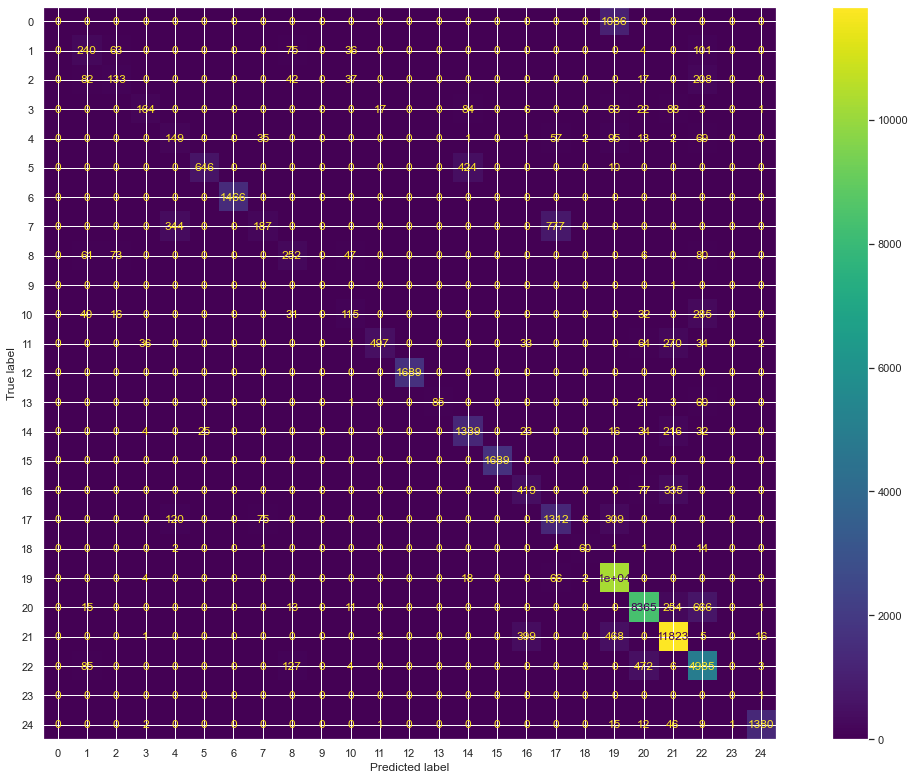

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

C:\Users\rodri\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


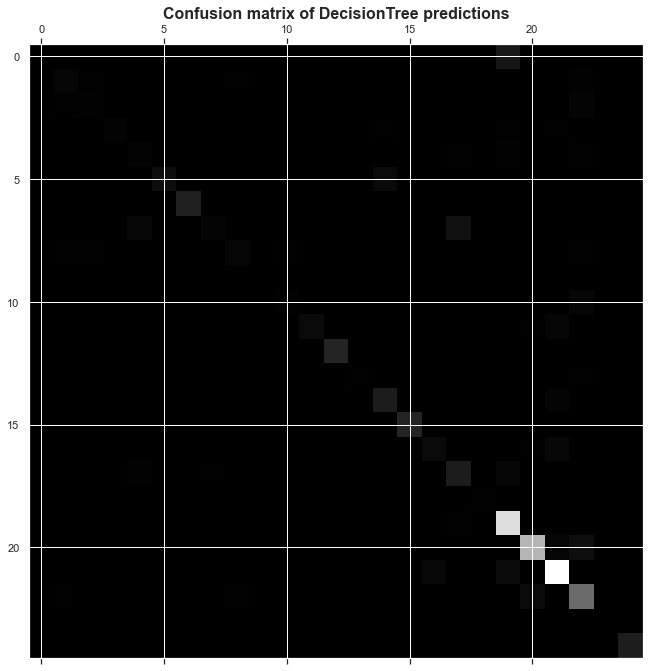

In [18]:
plt.matshow(cm, cmap=plt.cm.gray)
plt.title("Confusion matrix of DecisionTree predictions", weight='bold', size = '16')
plt.show();

(0.0, 200.0)

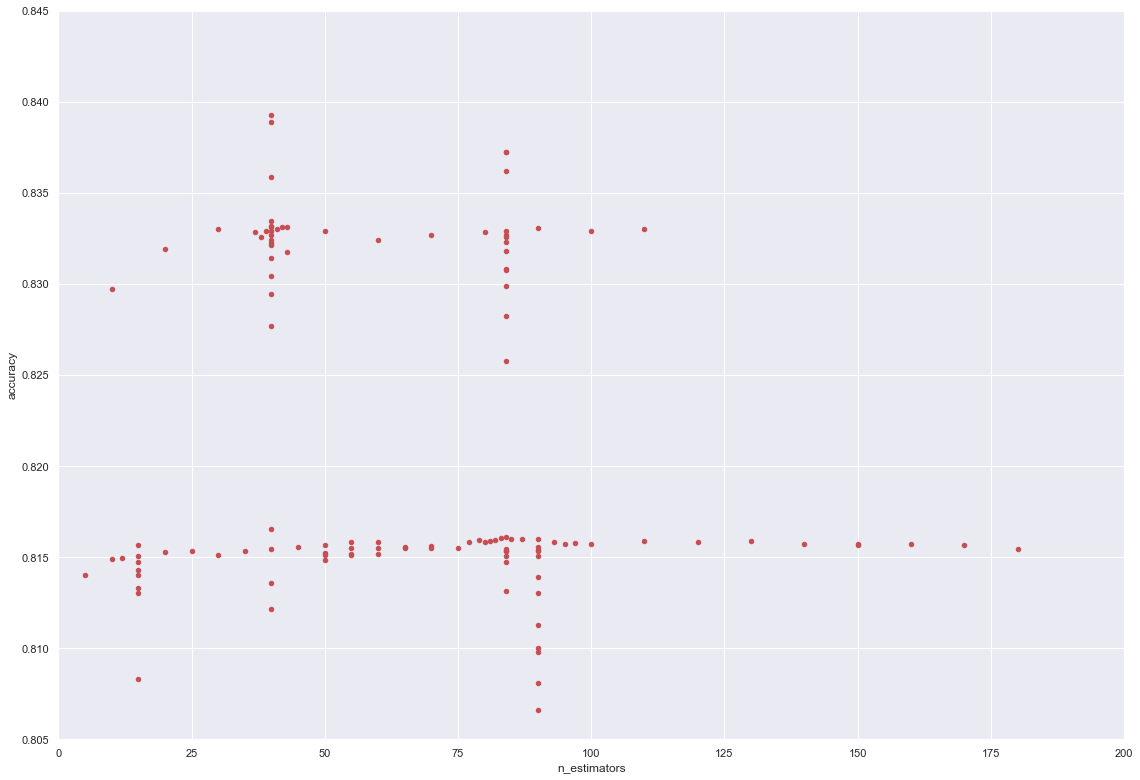

In [31]:
plt = df_models[~df_models["Random Sampling"].isin([1,2,3])].plot(kind="scatter", x="n_estimators", y="accuracy", c="r", alpha = 1)
plt.set_ylim(0.805, 0.845)
plt.set_xlim(0,200)